In [165]:
import matplotlib.pyplot as plt
import colorcet as cc
import numpy as np
import time
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d

try:
    plt.register_cmap(name='linear_kbgoy_20_95_c57', cmap=cc.cm['linear_kbgoy_20_95_c57'])
except:
    pass

C:\Users\Michiel\AppData\Local\Temp\ipykernel_13048\2329368845.py:10: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='linear_kbgoy_20_95_c57', cmap=cc.cm['linear_kbgoy_20_95_c57'])


In [166]:
number_of_files = 66 + 16

# 66 betrouwbare data, daarna veel ethanoldamp in de lucht (hoe kan dat nou?) 

data = []
data_T = [[], [], [], [], [], []]

for i in range(0, number_of_files+1):
    data.append([])
    t = []
    A0 = []
    A1 = []
    A2 = []
    # open_file = open(f"C:/Users/Michiel Erkamp/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    open_file = open(f"C:/Users/Michiel/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    for line in open_file:
        data_opgeknipt = line.split(',')
        try:
            data_opgeknipt = line.split(',')
            t.append(float(data_opgeknipt[0]))
            A0.append(float(data_opgeknipt[1]))
            A1.append(float(data_opgeknipt[2])) 
            A2.append(float(data_opgeknipt[3]))
        except:
            if data_opgeknipt[0] == "height of setup:":
                height = round(float(data_opgeknipt[1]) - (13.1 + 42.4 + 40.29*0), 2)
    open_file.close()

    A_avg = np.mean(np.array([A0, A1, A2]), axis=0)

    data[i-0].append([height] * len(t))
    data[i-0].append(t)
    data[i-0].append(A0)
    data[i-0].append(A1)
    data[i-0].append(A2)
    data[i-0].append(A_avg)

    data_T[0].append([height] * len(t))
    data_T[1].append(t)
    data_T[2].append(A0)
    data_T[3].append(A1)
    data_T[4].append(A2)
    data_T[5].append(A_avg)


data_all = [[], [], [], [], [], []]
for i in range(len(data_all)):
    for row in data_T[i]:
        data_all[i].extend(row)

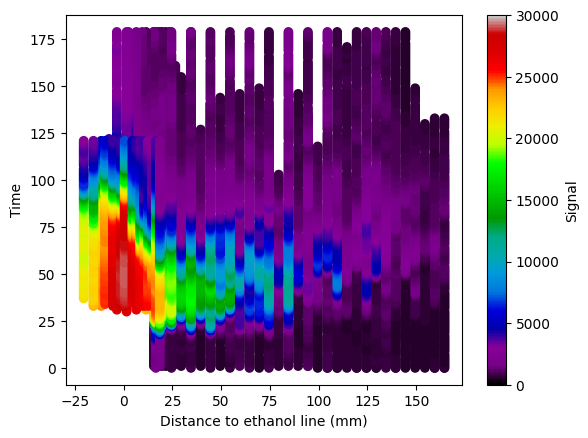

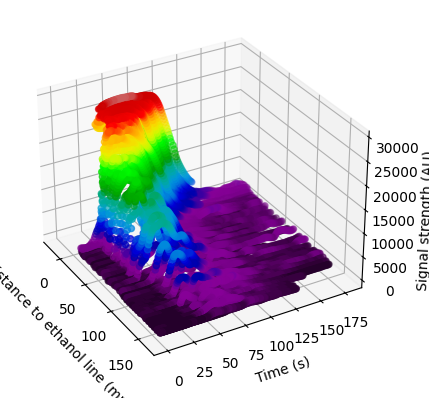

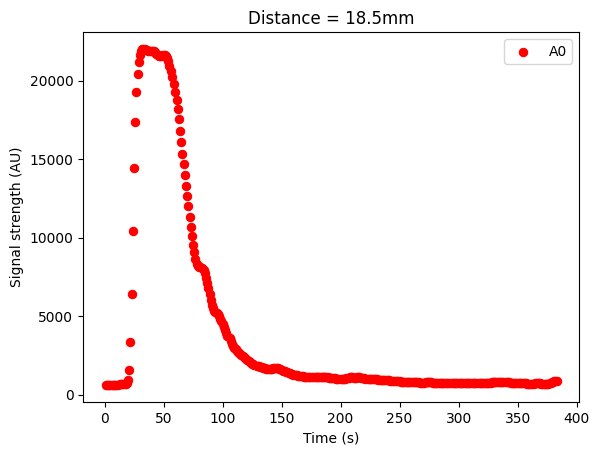

<Figure size 640x480 with 0 Axes>

In [167]:
indices = np.where(np.array(data_all[1]) < 180)[0]
# print(indices)

x = np.array(data_all[0])[indices]
y = np.array(data_all[1])[indices]
z = np.array(data_all[2])[indices]

# Plotting
fig, ax = plt.subplots()
# c = ax.tricontourf(x, y, z, c=z, cmap='nipy_spectral', levels=np.linspace(0, 30000, 256), vmin=0, vmax=30000)
c = ax.scatter(x, y, c=z, cmap='nipy_spectral', vmin=0, vmax=30000)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time")
cb = fig.colorbar(c, ax=ax, label="Signal")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()
plt.clf()

ax = plt.axes(projection='3d')
# ax.plot_trisurf(x,y,z, cmap='hsv')
ax.scatter3D(x,y,z, '.', c=z, cmap='nipy_spectral', vmin=0, vmax=30000) # magma
ax.view_init(elev=30, azim=-30)
ax.set_xlabel(r'Distance to ethanol line (mm)')
ax.set_ylabel(r'Time (s)')
ax.set_zlabel(r'Signal strength (AU)')
plt.savefig('exp2_alldata.png')
plt.show()
plt.clf()

plt.scatter(data[5][1], data[5][2], color="red", linewidth=0.8, label="A0")

plt.title(f"Distance = {data[5][0][0]}mm")
plt.legend(loc='best')
plt.xlabel("Time (s)")
plt.ylabel("Signal strength (AU)")
plt.savefig('exp2_rawdata.png')
plt.show()
plt.clf()

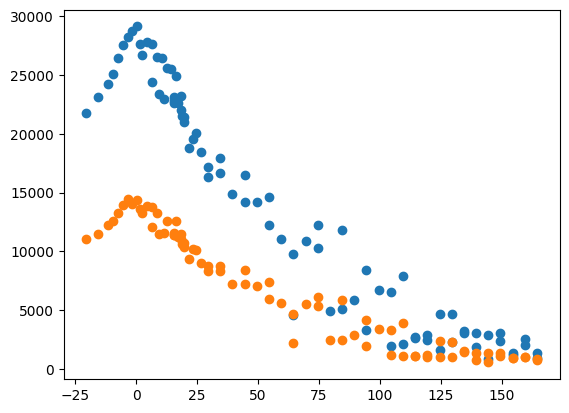

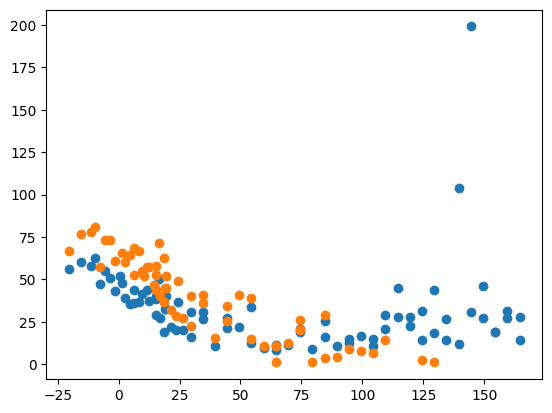

<Figure size 640x480 with 0 Axes>

In [168]:
height_top = []
time_top = []
signal_top = []
time_halftop = []
signal_halftop = []
time_quartertop = []
signal_quartertop = []


for measurement in data:
    measurement = np.array(measurement)
    index = np.where(measurement[2] == np.max(measurement[2]))[0][0]
    height_top.append(measurement[0][index])
    time_top.append(measurement[1][index])
    signal_top.append(measurement[2][index])

    # deterine half top statistics
    epsilon = 500
    index1 = np.where(measurement[2] > 0.5*np.max(measurement[2]) - epsilon)[0]
    index2 = np.where(measurement[2] < 0.5*np.max(measurement[2]) + epsilon)[0]
    index3 = np.where(measurement[1] > time_top[-1])[0]

    index = np.intersect1d(np.intersect1d(index1, index2), index3)

    # select first continious sequence
    diffs = np.diff(index)
    split_index = np.where(diffs != 1)[0]
    end = split_index[0] + 1 if len(split_index) > 0 else len(index)
    index = index[:end]

    time_halftop.append(np.mean(measurement[1][index]))
    signal_halftop.append(np.mean(measurement[2][index]))

    # deterine statistics around threshold of 5000
    epsilon = 500
    index1 = np.where(measurement[2] > 5000 - epsilon)[0]
    index2 = np.where(measurement[2] < 5000 + epsilon)[0]
    index3 = np.where(measurement[1] > time_top[-1])[0]

    index = np.intersect1d(np.intersect1d(index1, index2), index3)

    # select first continious sequence
    diffs = np.diff(index)
    split_index = np.where(diffs != 1)[0]
    end = split_index[0] + 1 if len(split_index) > 0 else len(index)
    index = index[:end]

    time_quartertop.append(np.mean(measurement[1][index]))
    signal_quartertop.append(np.mean(measurement[2][index]))

time_to_half = np.array(time_halftop) - np.array(time_top)
time_to_quarter = np.array(time_quartertop) - np.array(time_top)
height_top = np.array(height_top)

plt.scatter(height_top, signal_top)
plt.scatter(height_top, signal_halftop)
plt.show()
plt.clf()

plt.scatter(height_top, time_to_half)
plt.scatter(height_top, time_to_quarter)

plt.show()
plt.clf()

In [169]:
index1 = np.where(height_top > 15.5)[0]
index2 = np.where(height_top < 100)[0]
index = np.intersect1d(index1, index2)

time_to_half_avg = np.nanmean(time_to_half[index])
time_to_quarter_avg = np.nanmean(time_to_quarter[index])

print(time_to_half_avg)
print(time_to_quarter_avg)

22.28921568627451
28.337052341597797


Now more rigurous for more thresholds

In [170]:
threshold_min = 1000
threshold_size = 100
thresholds = np.linspace(threshold_min,30000,num=int((30000-threshold_min)/threshold_size)+1)
binned_distance = np.linspace(0,100,11)
time_of_use = []

for threshold in thresholds:
    distance = []
    time_top = []
    time_threshold_left = []
    time_threshold_right = []
    signal_threshold = []

    binned_time_to_threshold = []
    
    for measurement in data:

        measurement = np.array(measurement)
        index = np.where(measurement[2] == np.max(measurement[2]))[0][0]
        distance.append(measurement[0][0])
        time_top.append(measurement[1][index])
        
        if np.max(measurement[2]) < threshold:
            time_threshold_left.append(np.nan) # 0 for black values, NaN for white values
            time_threshold_right.append(np.nan) # 0 for black values, NaN for white values
        else:
            # left side

            # top-left
            index_left = np.where(measurement[1] <= time_top[-1])[0]
            index_top = np.where(measurement[2] >= threshold)[0]
            index_top_left = np.intersect1d(index_left, index_top)

            # select last continious sequence
            diffs = np.diff(index_top_left)
            split_index = np.where(diffs != 1)[0]
            start = split_index[-1] + 1 if len(split_index) > 0 else 0
            index_top_left = index_top_left[start:]

            # select first point above threshold
            time_threshold_top_left = measurement[1][index_top_left[0]]

            # bottom-left
            index_left = np.where(measurement[1] <= time_top[-1])[0]
            index_bottom = np.where(measurement[2] <= threshold)[0]
            index_bottom_left = np.intersect1d(index_left, index_bottom)

            # select last continious sequence
            diffs = np.diff(index_bottom_left)
            split_index = np.where(diffs != 1)[0]
            start = split_index[-1] + 1 if len(split_index) > 0 else 0
            index_bottom_left = index_bottom_left[start:]

            # select first point above threshold
            if len(index_bottom_left) > 0:
                time_threshold_bottom_left = measurement[1][index_bottom_left[-1]]
            else:
                time_threshold_bottom_left = time_threshold_top_left

            # left
            time_threshold_left.append((time_threshold_top_left + time_threshold_bottom_left)/2)


            # right side

            # top-right
            index_right = np.where(measurement[1] >= time_top[-1])[0]
            index_top = np.where(measurement[2] >= threshold)[0]
            index_top_right = np.intersect1d(index_right, index_top)

            # select first continious sequence
            diffs = np.diff(index_top_right)
            split_index = np.where(diffs != 1)[0]
            end = split_index[0] + 1 if len(split_index) > 0 else len(index_top_right)
            index_top_right = index_top_right[:end]

            # select first point above threshold
            time_threshold_top_right = measurement[1][index_top_right[-1]]

            # bottom-right
            index_right = np.where(measurement[1] >= time_top[-1])[0]
            index_bottom = np.where(measurement[2] <= threshold)[0]
            index_bottom_right = np.intersect1d(index_right, index_bottom)

            # select first continious sequence
            diffs = np.diff(index_bottom_right)
            split_index = np.where(diffs != 1)[0]
            end = split_index[0] + 1 if len(split_index) > 0 else len(index_bottom_right)
            index_bottom_right = index_bottom_right[:end]

            # select first point above threshold
            if len(index_bottom_right) > 0:
                time_threshold_bottom_right = measurement[1][index_bottom_right[0]]
            else:
                time_threshold_bottom_right = np.nan #time_threshold_top_right
            

            # right
            time_threshold_right.append((time_threshold_top_right + time_threshold_bottom_right)/2)
    
    # time_above_threshold = np.array(time_threshold_right) - np.array(time_top)
    time_above_threshold = np.array(time_threshold_right) - np.array(time_threshold_left)
    distance = np.array(distance)

    # plt.scatter(distance, time_above_threshold)

    # for bin in binned_distance:
    #     index1 = np.where(distance > bin-5)[0]
    #     index2 = np.where(distance < bin+5)[0]
    #     index = np.intersect1d(index1, index2)

    #     binned_time_to_threshold.append(np.nanmean(time_above_threshold[index]))
    
    # time_of_use.append(binned_time_to_threshold)
    time_of_use.append(time_above_threshold)
    
    # plt.plot(binned_distance, binned_time_to_threshold)
    # plt.scatter(binned_distance, binned_time_to_threshold)
    
    # index1 = np.where(distance > 15.5)[0]
    # index2 = np.where(distance < 100)[0]
    # index = np.intersect1d(index1, index2)

    # time_to_threshold_avg = np.nanmean(time_above_threshold[index])

    # print(threshold, time_to_threshold_avg)

time_of_use = np.array(time_of_use)

C:\Users\Michiel\AppData\Local\Temp\ipykernel_13048\4165589825.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(


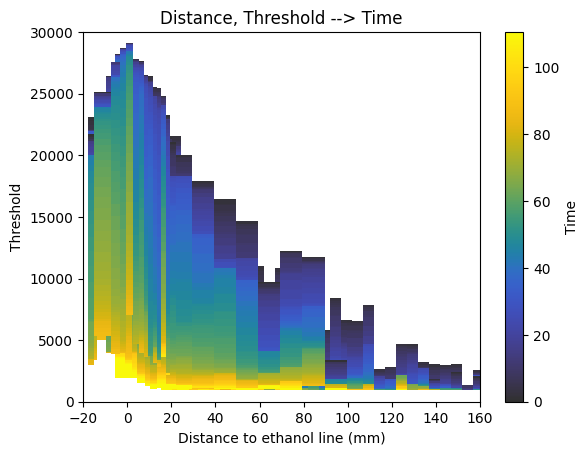

<Figure size 640x480 with 0 Axes>

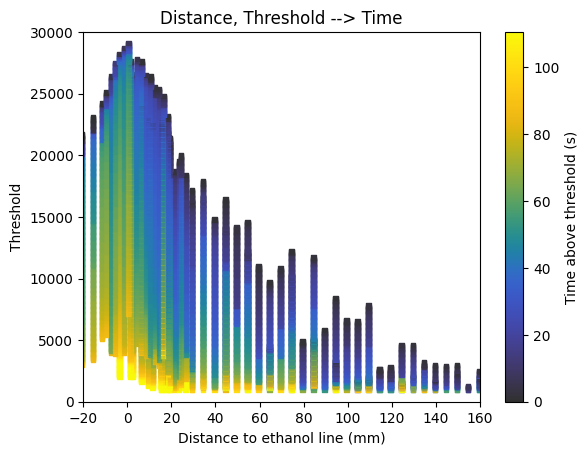

<Figure size 640x480 with 0 Axes>

In [171]:
distance_mesh, threshold_mesh = np.meshgrid(distance, thresholds)

vmax = np.nanpercentile(time_of_use, 99)

fig, ax = plt.subplots()
ax.set_title('Distance, Threshold --> Time')
c = ax.pcolormesh(
    distance_mesh,
    threshold_mesh,
    time_of_use,
    cmap='linear_kbgoy_20_95_c57',
    shading='auto',
    vmin=0,
    vmax=vmax
)
ax.set_xlim(-20,160)
ax.set_ylim(0,30000)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Threshold")
fig.colorbar(c, ax=ax, label="Time")
plt.show()
plt.clf()

fig, ax = plt.subplots()
ax.set_title('Distance, Threshold --> Time')
c = ax.scatter(
    distance_mesh,
    threshold_mesh,
    c=time_of_use,
    cmap='linear_kbgoy_20_95_c57',
    marker='s',
    s=10,
    vmin=0,
    vmax=vmax
)
ax.set_xlim(-20,160)
ax.set_ylim(0,30000)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Threshold")
fig.colorbar(c, ax=ax, label="Time above threshold (s)")
plt.show()
plt.clf()

In [172]:
# Invert the mapping: from (threshold, distance) -> time
# to (distance, time) -> threshold

# Flatten the data to points for interpolation
threshold_values = []
distance_values = []
time_values = []

for i, t in enumerate(thresholds):
    for j, d in enumerate(distance):
        time = time_of_use[i, j]
        if not np.isnan(time):# and 0<d:  # Only keep valid data
            threshold_values.append(t)
            distance_values.append(d)
            time_values.append(time)


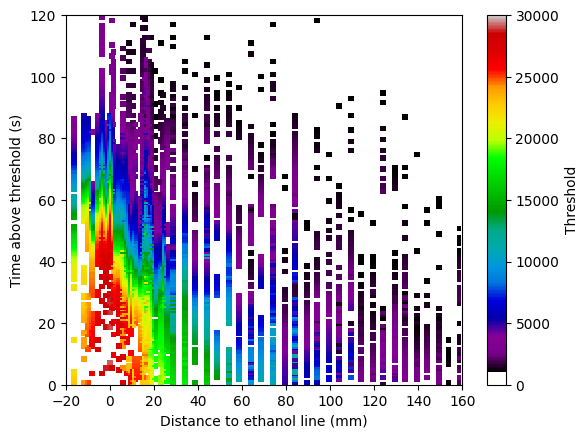

<Figure size 640x480 with 0 Axes>

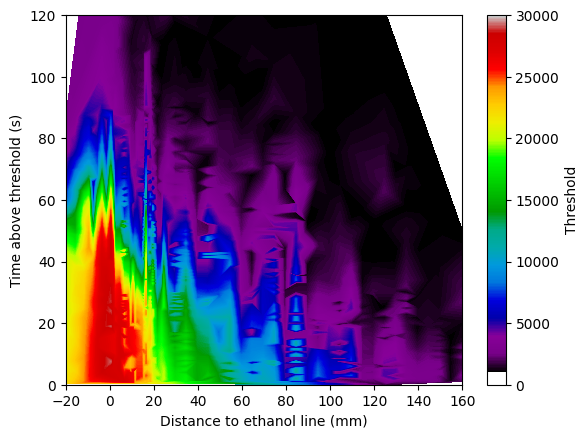

<Figure size 640x480 with 0 Axes>

In [173]:
# Define bin edges
distance_bins = np.linspace(0-20, 160, 200)
time_bins = np.linspace(0, 120, 200)

# Bin the data to a grid (mean threshold in each bin)
stat, x_edges, y_edges, _ = binned_statistic_2d(
    distance_values,
    time_values,
    threshold_values,
    statistic='mean',
    bins=[distance_bins, time_bins]
)

# Create a mask of valid data (1 = valid, 0 = NaN)
valid_mask = ~np.isnan(stat)
stat_filled = np.nan_to_num(stat, nan=0)

# Apply Gaussian filter to data and mask separately
smoothed_data = gaussian_filter(stat_filled, sigma=0.3)
smoothed_mask = gaussian_filter(valid_mask.astype(float), sigma=0.3)

# Normalize to correct for masked regions
with np.errstate(invalid='ignore', divide='ignore'):
    stat_smooth = smoothed_data / smoothed_mask
    stat_smooth[smoothed_mask == 0] = np.nan  # retain NaNs where no data exists

# Create mesh for plotting
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

# Plot smoothed heatmap
fig, ax = plt.subplots()
# ax.set_title('Threshold, individual data')
c = ax.pcolormesh(X, Y, stat_smooth.T, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
ax.set_xlim(-20, 160)
ax.set_ylim(0, 120)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time above threshold (s)")
cb = fig.colorbar(c, ax=ax, label="Threshold")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()

# Plotting
fig, ax = plt.subplots()
# ax.set_title('Threshold, triangular connection')
ax.tricontourf(distance_values, time_values, threshold_values, levels=np.linspace(threshold_min, 30000, 256), cmap='nipy_spectral')
ax.set_xlim(-20, 160)
ax.set_ylim(0, 120)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time above threshold (s)")
cb = fig.colorbar(c, ax=ax, label="Threshold")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()
plt.clf()

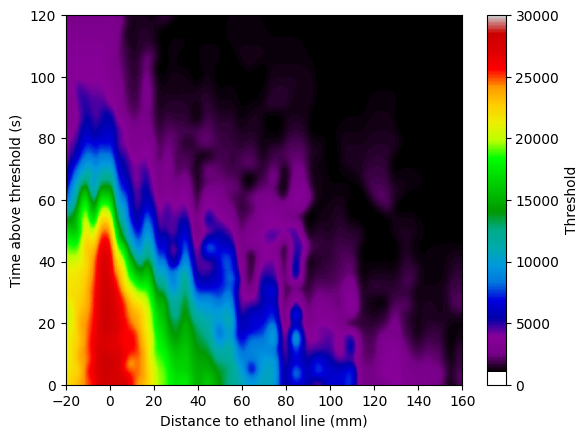

<Figure size 640x480 with 0 Axes>

In [174]:
# Create grid for distance and time
distance_grid = np.linspace(min(distance), max(distance), 1000)
time_grid = np.linspace(min(time_values), max(time_values), 1000)
distance_mesh, Time_mesh = np.meshgrid(distance_grid, time_grid)

# Interpolate threshold values over this new grid
points = np.column_stack((distance_values, time_values))
threshold_grid = griddata(points, threshold_values, (distance_mesh, Time_mesh), method='nearest')
threshold_grid = gaussian_filter(threshold_grid, sigma=10)

# Plotting
fig, ax = plt.subplots()
# ax.set_title('Threshold, Smoothed')
c = ax.pcolormesh(distance_mesh, Time_mesh, threshold_grid, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
ax.set_xlim(-20,160)
ax.set_ylim(0,120)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time above threshold (s)")
cb = fig.colorbar(c, ax=ax, label="Threshold")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()

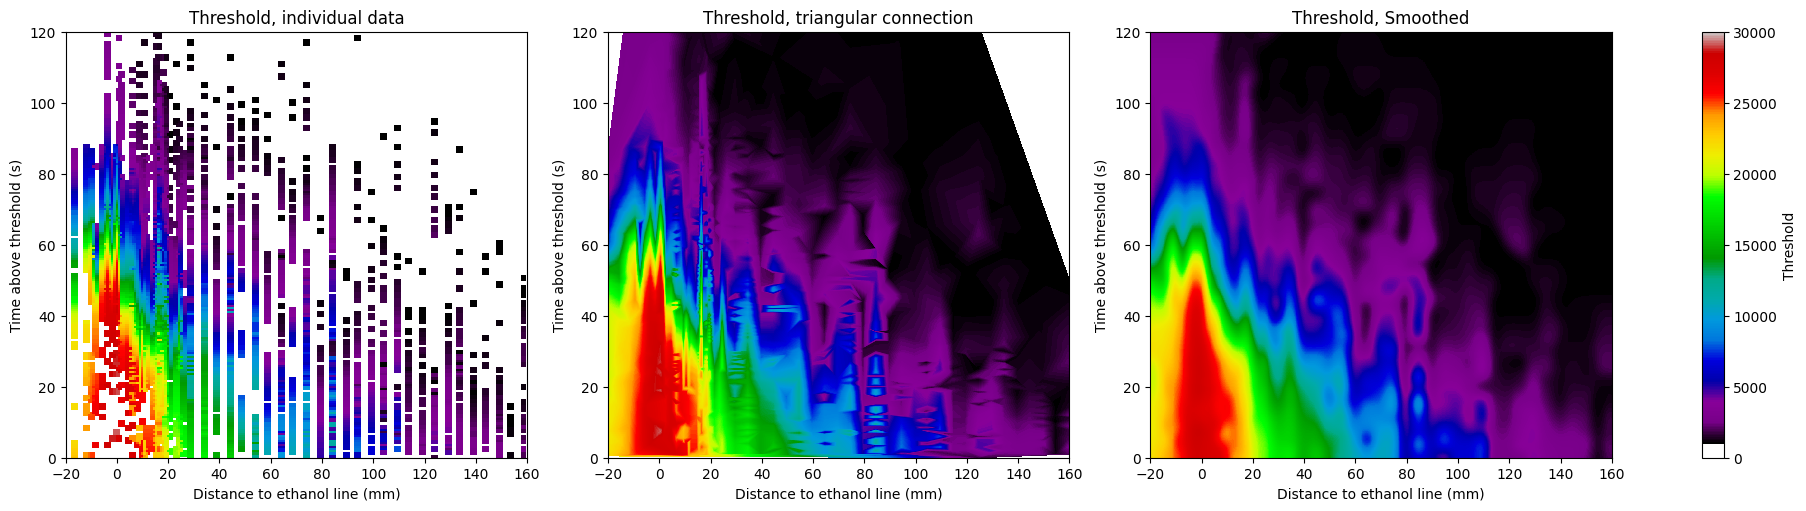

<Figure size 640x480 with 0 Axes>

In [175]:
# Show all plots side by side
# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1,3, figsize=(18, 5), constrained_layout=True)

# Plot on the left
axes[0].set_title('Threshold, individual data')
c = axes[0].pcolormesh(X, Y, stat_smooth.T, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
axes[0].set_xlim(-20, 160)
axes[0].set_ylim(0, 120)
axes[0].set_xlabel("Distance to ethanol line (mm)")
axes[0].set_ylabel("Time above threshold (s)")

# Plot in the middle
axes[1].set_title('Threshold, triangular connection')
axes[1].tricontourf(distance_values, time_values, threshold_values, levels=np.linspace(threshold_min, 30000, 256), cmap='nipy_spectral')
axes[1].set_xlim(-20, 160)
axes[1].set_ylim(0, 120)
axes[1].set_xlabel("Distance to ethanol line (mm)")
axes[1].set_ylabel("Time above threshold (s)")

# Plot on the right
axes[2].set_title('Threshold, Smoothed')
axes[2].pcolormesh(distance_mesh, Time_mesh, threshold_grid, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
axes[2].set_xlim(-20, 160)
axes[2].set_ylim(0, 120)
axes[2].set_xlabel("Distance to ethanol line (mm)")
axes[2].set_ylabel("Time above threshold (s)")

# Add a shared colorbar on the right side
cb = fig.colorbar(c, ax=axes, location='right', label="Threshold")
cb.set_ticks(range(0,30001,5000))

plt.show()
plt.clf()

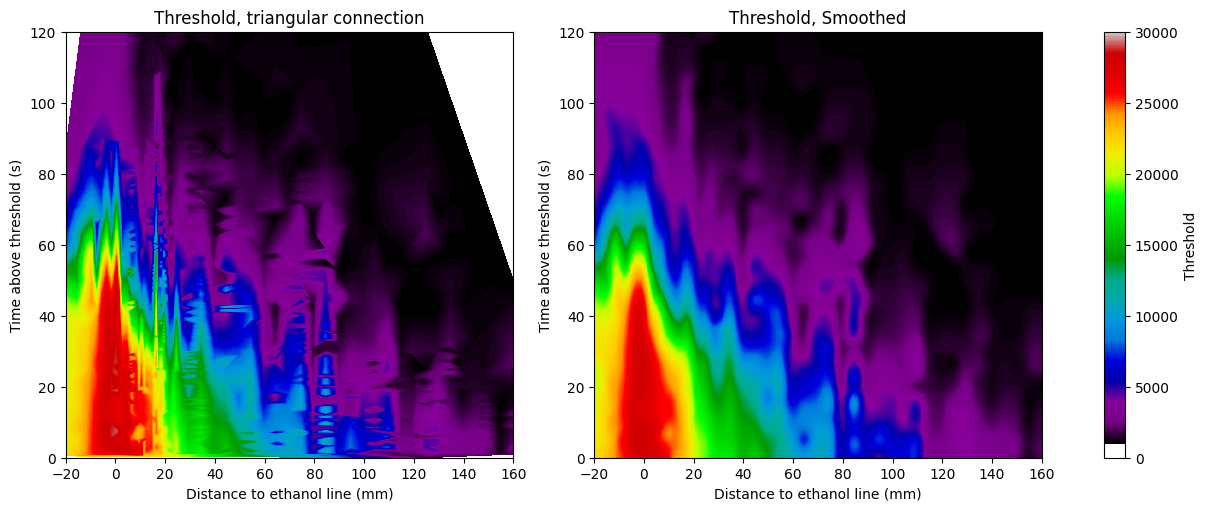

<Figure size 640x480 with 0 Axes>

In [176]:
# Show all plots side by side
# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True)

# Plot in the middle
axes[0].set_title('Threshold, triangular connection')
axes[0].tricontourf(distance_values, time_values, threshold_values, levels=np.linspace(threshold_min, 30000, 256), cmap='nipy_spectral')
axes[0].set_xlim(-20, 160)
axes[0].set_ylim(0, 120)
axes[0].set_xlabel("Distance to ethanol line (mm)")
axes[0].set_ylabel("Time above threshold (s)")

# Plot on the right
axes[1].set_title('Threshold, Smoothed')
c = axes[1].pcolormesh(distance_mesh, Time_mesh, threshold_grid, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
axes[1].set_xlim(-20, 160)
axes[1].set_ylim(0, 120)
axes[1].set_xlabel("Distance to ethanol line (mm)")
axes[1].set_ylabel("Time above threshold (s)")

# Add a shared colorbar on the right side
cb = fig.colorbar(c, ax=axes, location='right', label="Threshold")
cb.set_ticks(range(0,30001,5000))

plt.show()
plt.clf()

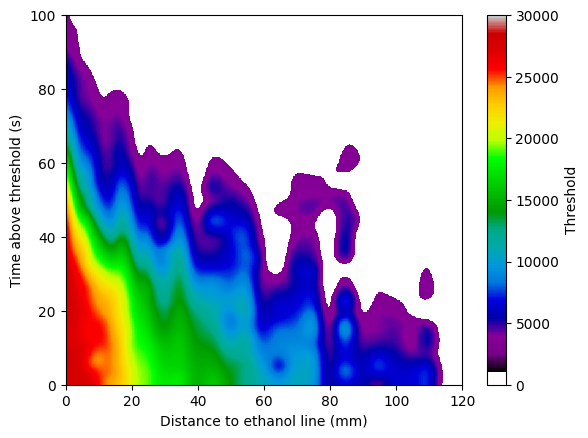

<Figure size 640x480 with 0 Axes>

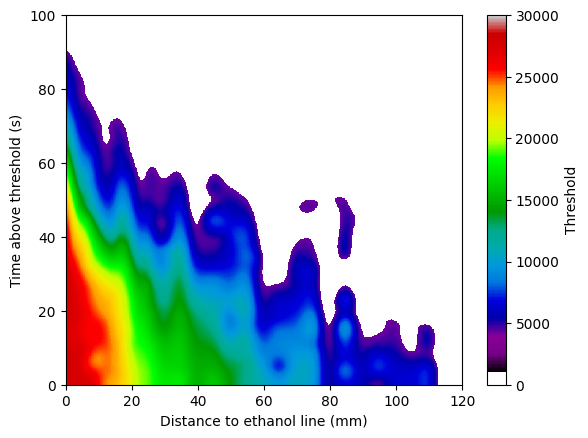

<Figure size 640x480 with 0 Axes>

In [177]:
index = np.where(threshold_grid < 3203)
threshold_grid[index] = np.nan

# Plotting
fig, ax = plt.subplots()
# ax.set_title('Threshold, Smoothed')
c = ax.pcolormesh(distance_mesh, Time_mesh, threshold_grid, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
ax.set_xlim(0,120)
ax.set_ylim(0,100)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time above threshold (s)")
cb = fig.colorbar(c, ax=ax, label="Threshold")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()


index = np.where(threshold_grid < 4229)
threshold_grid[index] = np.nan

# Plotting
fig, ax = plt.subplots()
# ax.set_title('Threshold, Smoothed')
c = ax.pcolormesh(distance_mesh, Time_mesh, threshold_grid, cmap='nipy_spectral', shading='auto', vmin=threshold_min, vmax=30000)
ax.set_xlim(0,120)
ax.set_ylim(0,100)
ax.set_xlabel("Distance to ethanol line (mm)")
ax.set_ylabel("Time above threshold (s)")
cb = fig.colorbar(c, ax=ax, label="Threshold")
cb.set_ticks(range(0,30001,5000))
plt.show()
plt.clf()

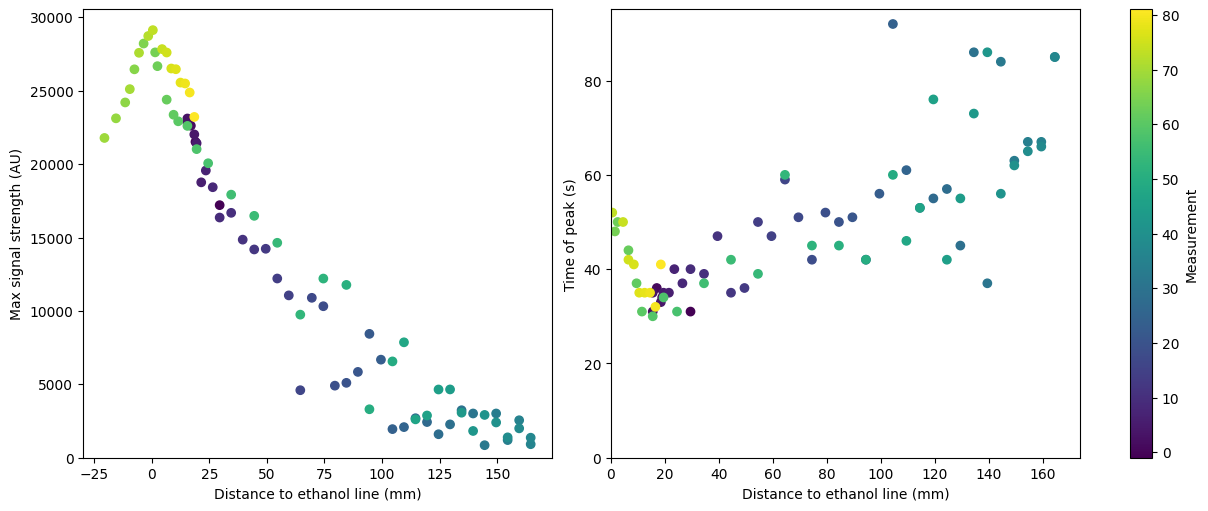

<Figure size 640x480 with 0 Axes>

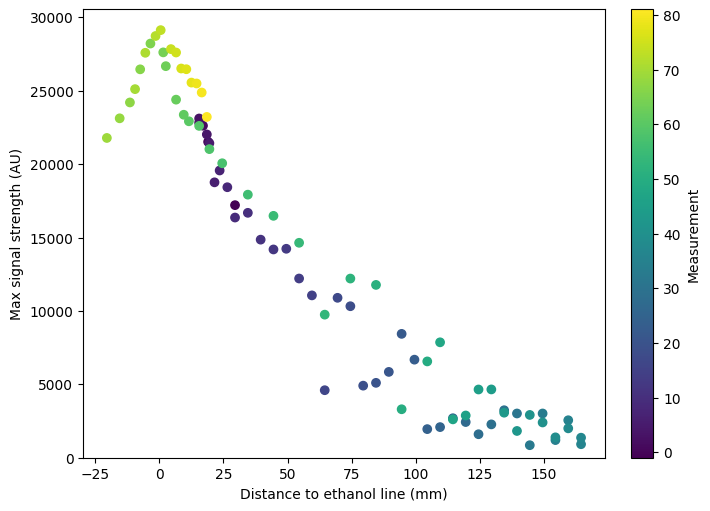

<Figure size 640x480 with 0 Axes>

In [178]:
# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot on the left
sc = axes[0].scatter(height_top, signal_top, c=range(-1, number_of_files), cmap='viridis')
# axes[0].plot([0,150], [1000,1000])
# axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("Distance to ethanol line (mm)")
axes[0].set_ylabel("Max signal strength (AU)")

# Plot on the right
axes[1].scatter(height_top, time_top, c=range(-1, number_of_files), cmap='viridis')
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("Distance to ethanol line (mm)")
axes[1].set_ylabel("Time of peak (s)")

# Add a shared colorbar on the right side
cbar = fig.colorbar(sc, ax=axes, location='right', label='Measurement')

plt.show()
plt.clf()

# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

# Plot on the left
sc = axes.scatter(height_top, signal_top, c=range(-1, number_of_files), cmap='viridis')
# axes[0].plot([0,150], [1000,1000])
# axes[0].set_xlim(left=0)
axes.set_ylim(bottom=0)
axes.set_xlabel("Distance to ethanol line (mm)")
axes.set_ylabel("Max signal strength (AU)")

# Add a shared colorbar on the right side
cbar = fig.colorbar(sc, ax=axes, location='right', label='Measurement')

plt.show()
plt.clf()

Finding location of line

-0.0024543947498650714


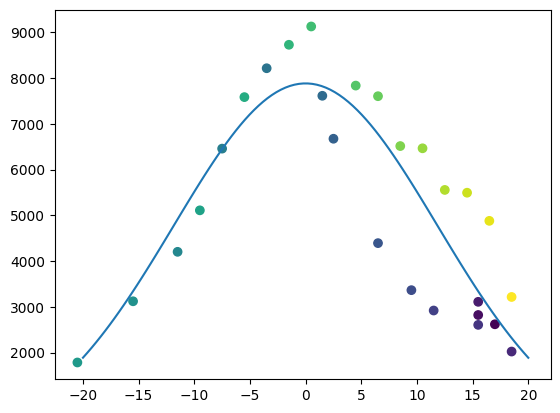

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 27
    # variables        = 3
    chi-square         = 32383989.6
    reduced chi-square = 1349332.90
    Akaike info crit   = 383.928122
    Bayesian info crit = 387.815632
    R-squared          = 0.75521206
[[Variables]]
    amplitude:  233647.603 +/- 14542.5194 (6.22%) (init = 11000)
    center:    -0.00245439 +/- 0.79519784 (32398.94%) (init = 0)
    sigma:      11.8250682 +/- 0.89553368 (7.57%) (init = 20)
    fwhm:       27.8459071 +/- 2.10882061 (7.57%) == '2.3548200*sigma'
    height:     7882.56867 +/- 410.879392 (5.21%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.7311
    C(amplitude, center) = -0.4824
    C(center, sigma)     = -0.3974


<Figure size 640x480 with 0 Axes>

In [179]:
from lmfit import models

index_x_min = np.where(height_top == np.min(height_top))[0][0]

index_peak = np.where(np.array(signal_top) >= signal_top[index_x_min])[0]

x = np.array(height_top)[index_peak]
y = np.array(signal_top)[index_peak] - 20000

model = models.GaussianModel()

result = model.fit(y, x=x, weights=1, amplitude=11000, center=0, sigma=20)

amplitude = result.params["amplitude"].value
center = result.params["center"].value
sigma = result.params["sigma"].value

print(center)

plt.scatter(x, y, c=range(len(x)))

x = np.linspace(-20,20,100)
y = amplitude / (np.sqrt(2.0 * np.pi) * sigma) * np.exp(-np.power((x - center) / sigma, 2.0) / 2)

plt.plot(x,y)
plt.show()
plt.clf()

print(result.fit_report())

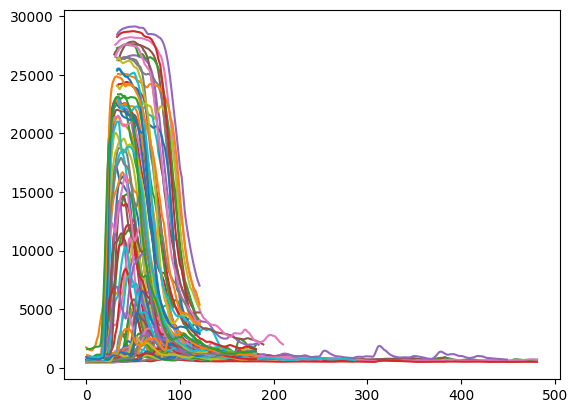

<Figure size 640x480 with 0 Axes>

In [180]:
for i in range(len(data)):
    plt.plot(np.array(data[i][1]), data[i][2], label=f"{i}")

# plt.legend(loc="best")

plt.show()
plt.clf()

4774.504678978436


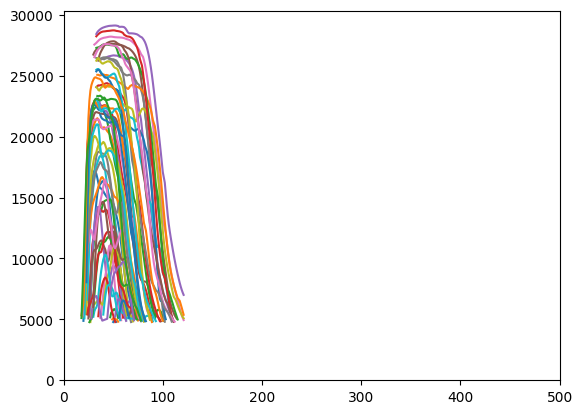

<Figure size 640x480 with 0 Axes>

In [181]:
baselines = []

for i in range(len(data)):
    baseline_i = np.mean(data[i][2][-30:])
    baselines.append(baseline_i)

baseline = np.mean(baselines)
deviation = np.std(baselines)

threshold = baseline + deviation

print(threshold)


for i in range(len(data)):
    index = np.where(data[i][2] > threshold)[0]
    plt.plot(np.array(data[i][1])[index], np.array(data[i][2])[index])

plt.xlim(0,500)
plt.ylim(bottom=0)
plt.show()
plt.clf()